# 9. 추천 시스템

## 01 추천 시스템의 개요와 배경
추천 시스템의 유형
- 콘텐츠 기반 필터링
- 협업 필터링 : 최근접 이웃 협업 필터링, 잠재 요인 협업 필터링
- 대부분의 온라인 스토어에서 잠재 요인 협업 필터링 기반의 추천 시스템 적용

## 02 콘텐츠 기반 필터링 추천 시스템
사용자가 특정한 아이템을 매우 선호하는 경우, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템 추천

## 03 최근접 이웃 협업 필터링
- 사용자가 아이템에 매긴 평점 정보나 상품 구매 이력과 같은 사용자 행동 양식만을 기반으로 추천 수행
- 사용자-아이템 평점 매트릭스와 같은 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 예측 평가
- 행: 개별 사용자, 열: 개별 아이템
- 사용자-아이템 평점 행렬은 많은 아이템을 열로 가지는 다차원 행렬이며 사용자가 아이템에 대한 평점을 매기는 경우가 많지 않기 때문에 희소 행렬
- 특정 사용자와 타 사용자 간의 유사도를 측정한 뒤 가장 유사도가 높은 TOP-N 사용자를 추출해 그들이 선호하는 아이템을 추천하는 것
- 일반적으로 사용자 기반 보다 아이템 기반 협업 필터링이 정확도가 높음
- 주로 코사인 유사도 이용

- 사용자 기반 / 아이템 기반 최근접 이웃 협업 필터링

## 04 잠재 요인 협업 필터링
잠재 요인 협업 필터링
- 사용자-아이템 평점 매트릭스 속에 숨어 있는 잠재 요인을 추출해 추천 예측

행렬 분해
- M개의 사용자 행과 N개의 아이템 열을 가진 행렬 R은 행렬 분해를 통해 사용자-K차원 잠재 요인 행렬 P와 잠재 요인-아이템 행렬 Q.T로 분해
- 주로 SVD 방식을 이용하여 R 행렬을 P와 Q 행렬로 분해하지만 NaN 값이 없는 행렬에만 적용 가능
- 확률적 경사 하강법이나 ALS 방식을 이용해 SVD 수행

확률적 경사 하강법을 이용한 행렬 분해
- P와 Q 행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용 함수 최적화를 통해 P와 Q를 유추해내는 것

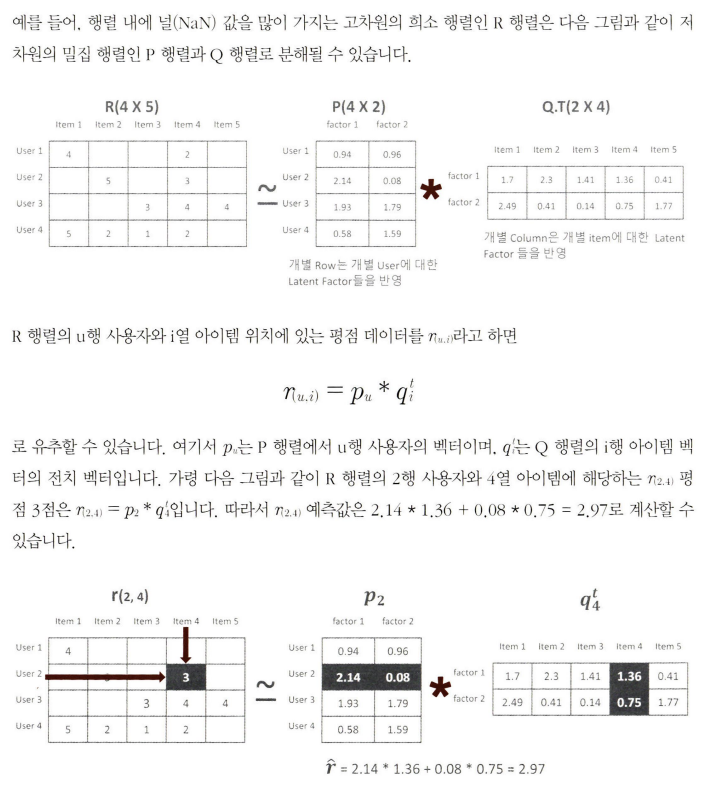

In [1]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재 요인 차원 K는 3으로 설정.
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN],
              [np.NaN, 5, np.NaN, 3, 1],
              [np.NaN, np.NaN, 3, 4, 4],
              [5, 2, 1, 2, np.NaN]])
num_users, num_items = R.shape
K=3

# P와 Q 행렬의 크기를 지정하고 정규 분포를 가진 임의의 값으로 입력합니다.
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users,K))
Q = np.random.normal(scale=1./K, size=(num_items,K))

In [2]:
# 실제 R 행렬과 예측 행렬의 오차를 구하는 함수
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [3]:
# SGD 기반으로 행렬 분해

# R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장
non_zeros = [ (i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0 ]

steps = 1000
learning_rate = 0.01
r_lambda = 0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
for step in range(steps):
  for i, j, r in non_zeros:
    # 실제 값과 예측 값의 차이인 오류 값 구함
    eij = r - np.dot(P[i, :], Q[j, :].T)
    # Regularization을 반영한 SGD 업데이트 공식 적용
    P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
    Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])
  rmse = get_rmse(R, P, Q, non_zeros)
  if (step % 50) == 0:
    print('### iteration step:', step, 'rmse:', rmse)

### iteration step: 0 rmse: 3.2388050277987723
### iteration step: 50 rmse: 0.4876723101369648
### iteration step: 100 rmse: 0.1564340384819247
### iteration step: 150 rmse: 0.07455141311978046
### iteration step: 200 rmse: 0.04325226798579314
### iteration step: 250 rmse: 0.029248328780878973
### iteration step: 300 rmse: 0.022621116143829466
### iteration step: 350 rmse: 0.019493636196525135
### iteration step: 400 rmse: 0.018022719092132704
### iteration step: 450 rmse: 0.01731968595344266
### iteration step: 500 rmse: 0.016973657887570753
### iteration step: 550 rmse: 0.016796804595895633
### iteration step: 600 rmse: 0.01670132290188466
### iteration step: 650 rmse: 0.01664473691247669
### iteration step: 700 rmse: 0.016605910068210026
### iteration step: 750 rmse: 0.016574200475705
### iteration step: 800 rmse: 0.01654431582921597
### iteration step: 850 rmse: 0.01651375177473524
### iteration step: 900 rmse: 0.01648146573819501
### iteration step: 950 rmse: 0.016447171683479155


In [4]:
# P * Q.T
pred_matrix = np.dot(P,Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]
